**A Twitter Sentimental Analyser** 
```c++
 __author__  =  'Strauss'
 __project__ =  'Machine Learning Proof of Concepts'
 __date__    =  '19/10/2020 01:51:02 (initial)'
```

In [153]:
import pandas as pd
import numpy as np
import pickle
import time
import itertools
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import TweetTokenizer
import re
import string
import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.multiclass import OneVsOneClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score,classification_report
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE 

#### Methods

In [2]:
def plot_confusion_matrix(cm, classes,normalize=False,cmap=plt.cm.Blues):
  title='Confusion Matrix Sentimental Analysis'
  try:
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True values')
    plt.xlabel('Predicted values')
    plt.tight_layout()
  except Exception as err:
    print('Erro ao plotar grafico: {0}'.format(err))

In [43]:
def clear_twitter_text(tweet):
    tweet = re.sub(r"http\S+", "", tweet).lower().replace('.','').replace(';','').replace('-','').replace(':','').replace(')','')   
    return (tweet)

In [45]:
def kill_stop_word(tweet):
    tweet = [i for i in tweet.split() if not i in stop_words]
    return (" ".join(tweet))    

#### Tokenizers ad Stop Words

In [48]:
nltk.download('stopwords')
nltk.download('rslp')

#stop_words = stopwords.words('portuguese')
stop_words = set(nltk.corpus.stopwords.words('portuguese'))
stop_words.remove('não')

tkn = RegexpTokenizer(r'\w+')
tw_tkn = TweetTokenizer()

[nltk_data] Downloading package stopwords to /home/oak/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to /home/oak/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


#### Environment Configurations

In [5]:
pth = '/media/oak/4D38-34DE1/DATA/social_media/twitter/'
drw_nm = 'drw_twitties_mg.csv'
x_nm = 'texto'
y_nm = 'classe_sentimento'
random_state = 1612

#### Data Clean

In [49]:
drw = pd.read_csv(pth + drw_nm, sep=',')
drw = drw[['Text','Classificacao']]
dcl = drw.rename(columns={'Text': x_nm , 'Classificacao': y_nm})
dcl = dcl[pd.notnull(dcl[x_nm])]
dcl.drop_duplicates([x_nm], inplace=True)
dcl[x_nm] = dcl[x_nm].apply(clear_twitter_text)
dcl[x_nm] = dcl[x_nm].apply(kill_stop_word)
dcl.shape

(5765, 2)

In [50]:
dcl.head(5)

,texto,classe_sentimento
0,���⛪ @ catedral santo antônio governador valad...,Neutro
1,"� @ governador valadares, minas gerais",Neutro
2,"�� @ governador valadares, minas gerais",Neutro
3,���,Neutro
4,��� psol vai questionar aumento vereadores pre...,Negativo


#### Data Analysis

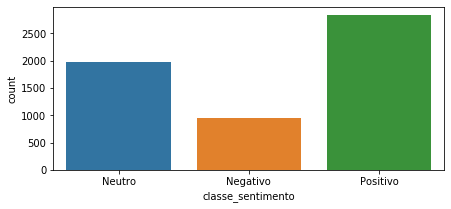

In [51]:
plt.figure(figsize=(7,3))
sb.countplot(x = y_nm, data = dcl)

In [52]:
dcl[y_nm].value_counts()

Positivo    2840
Neutro      1974
Negativo     951
Name: classe_sentimento, dtype: int64

In [53]:
dcl['tokens'] = dcl[x_nm].apply(tw_tkn.tokenize)
n_token = [word for tokens in dcl["tokens"] for word in tokens]
n_setence = [len(tokens) for tokens in dcl["tokens"]]
vocab = sorted(list(set(n_token)))
print('Vocabulario:{0}'.format(len(vocab)))
print('Registros:{0}'.format(len(n_setence)))
print('Tokens:{0}'.format(len(n_token)))

Vocabulario:7338
Registros:5765
Tokens:61803


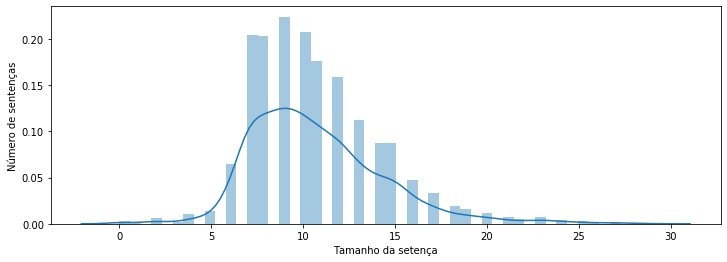

In [54]:
fig = plt.figure(figsize=(12, 4)) 
plt.xlabel('Tamanho da setença')
plt.ylabel('Número de sentenças')
sb.distplot(n_setence)

#### Vectorization

In [159]:
vec_tf = TfidfVectorizer(sublinear_tf=True, 
                        min_df=1, 
                        norm='l2', 
                        encoding='latin-1', 
                        ngram_range=(1, 2),
                        stop_words=stopwords.words('portuguese'),
                        tokenizer=tw_tkn.tokenize)

features_vec = vec_tf.fit_transform(dcl[x_nm])
Y = dcl[y_nm]
features_vec.shape

(5765, 25559)

In [160]:
n = 9000
ch2 = SelectKBest(score_func=chi2, k=n)
features_ch2_vec = ch2.fit_transform(features_vec, Y)
features_ch2_vec.shape

(5765, 9000)

#### Cross Validation

In [186]:
X_train,x_test,Y_train,y_test = train_test_split(features_ch2_vec,Y,shuffle=True,random_state = random_state)
X_train

<4323x9000 sparse matrix of type '<class 'numpy.float64'>'
	with 69430 stored elements in Compressed Sparse Row format>

#### Data Sampling

In [83]:
samp_smote = SMOTE(random_state = random_state) 
X_train_samp, Y_train_samp = samp_smote.fit_sample(X_train,Y_train) 
x_teste_samp, y_test_samp = samp_smote.fit_sample(x_test,y_test) 

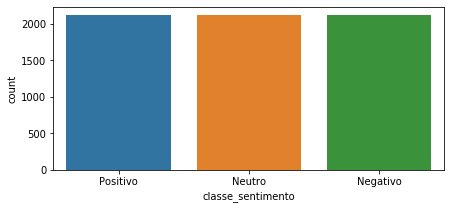

In [84]:
plt.figure(figsize=(7,3))
sb.countplot(x = y_nm, data = Y_train_samp.to_frame())

#### Models Evaluation

In [85]:
k_fold = 5
models      = []
results     = []
names       = []
vectorizers = []
models.append(('OneVsRest',OneVsRestClassifier(LinearSVC(random_state=random_state)))) 
models.append(('OneVsOne', OneVsOneClassifier(LinearSVC(random_state=random_state)))) 
models.append(('NB',       MultinomialNB())) 
models.append(('LR',       LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', multi_class='multinomial', n_jobs=-1, random_state=random_state)))
models.append(('RandomForest', RandomForestClassifier(n_estimators=10, random_state=random_state))) 
models.append(('ExtraTrees', ExtraTreesClassifier(n_estimators=10, random_state=random_state)))
models.append(('sgd', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=random_state, max_iter=5, tol=None)))
models.append(('svm',  (svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto'))))
#models.append(('AdaBoost', AdaBoostClassifier(random_state=random_state))) 
#models.append(('GradientBoosting', GradientBoostingClassifier(random_state=random_state))) 

#### Training

In [86]:
print('Inicio do Treino...')
k_fold=5
start=time.time() 
for nme_model, model in models:
  model.fit(X_train_samp,Y_train_samp)
  metrics_k_fold = cross_val_score(model, X_train_samp, Y_train_samp, cv=k_fold, scoring='f1_macro')   
  elapsed = time.time() - start
  results.append(metrics_k_fold)
  names.append(nme_model)
  print('Modelo:{0} Média :{1}  STD:{2} Tempo execucao:{3}'.format(nme_model.ljust(16,' '),round(metrics_k_fold.mean(),5),round(metrics_k_fold.std(),5),round(elapsed,4)))  
print('Fim do Treino')
print('Tempo gasto:{0}'.format(time.time() - start))  

Inicio do Treino...
Modelo:OneVsRest        Média :0.97283  STD:0.00934 Tempo execucao:0.5335
Modelo:OneVsOne         Média :0.9719  STD:0.01054 Tempo execucao:0.887
Modelo:NB               Média :0.95614  STD:0.01108 Tempo execucao:1.0235
Modelo:LR               Média :0.97687  STD:0.01035 Tempo execucao:3.0788
Modelo:RandomForest     Média :0.95612  STD:0.02521 Tempo execucao:4.7373
Modelo:ExtraTrees       Média :0.96635  STD:0.01922 Tempo execucao:7.5279
Modelo:sgd              Média :0.95246  STD:0.01459 Tempo execucao:7.6754
Modelo:svm              Média :0.96474  STD:0.00944 Tempo execucao:20.4649
Fim do Treino
Tempo gasto:20.465298891067505


#### Test

In [87]:
metric=[]
start = time.time()
for name, model in models:
  yp = model.predict(x_teste_samp)
  score = round(f1_score(y_test_samp, yp, pos_label=1, average='macro'),4)  
  elapsed = time.time() - start
  metric.append(score)
  print('Modelo:{0}  Score:{1}  Tempo execucao:{2}'.format(name.ljust(20,' '),round(score,5),round(elapsed,4)))

Modelo:OneVsRest             Score:0.9278  Tempo execucao:0.0133
Modelo:OneVsOne              Score:0.9251  Tempo execucao:0.0298
Modelo:NB                    Score:0.9297  Tempo execucao:0.041
Modelo:LR                    Score:0.9284  Tempo execucao:0.0553
Modelo:RandomForest          Score:0.9207  Tempo execucao:0.0922
Modelo:ExtraTrees            Score:0.9163  Tempo execucao:0.1205
Modelo:sgd                   Score:0.901  Tempo execucao:0.1296
Modelo:svm                   Score:0.9185  Tempo execucao:0.7303


In [88]:
model_win = models[3][1]
model_win

LogisticRegression(C=30.0, class_weight='balanced', multi_class='multinomial',
                   n_jobs=-1, random_state=1612, solver='newton-cg')

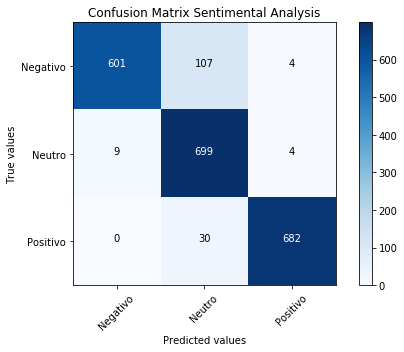

In [147]:
classes = ['Negativo', 'Neutro', 'Positivo']
yp = model_win.predict(x_teste_samp)
cm=confusion_matrix(y_test_samp, yp)
np.set_printoptions(precision=2)
plt.figure(figsize=(7,5))
plot_confusion_matrix(cm, classes)

In [149]:
print(classification_report(y_test_samp,yp,classes))

              precision    recall  f1-score   support

    Negativo       0.99      0.84      0.91       712
      Neutro       0.84      0.98      0.90       712
    Positivo       0.99      0.96      0.97       712

    accuracy                           0.93      2136
   macro avg       0.94      0.93      0.93      2136
weighted avg       0.94      0.93      0.93      2136



#### Save steps pipeline models to deploy

In [90]:
model_nm = "c1_classifier.pkl"  
vec_nm   = 'c1_vect.pkl'
ch2_nm   = 'c1_ch2.pkl'
samp_nm  = 'c1_sample.pkl'

with open(model_nm, 'wb') as file:  
  pickle.dump(model_win, file)

with open(vec_nm, 'wb') as file:  
  pickle.dump(vec_tf, file)

with open(ch2_nm, 'wb') as file:  
  pickle.dump(ch2, file)

with open(samp_nm, 'wb') as file:  
  pickle.dump(samp_smote, file)

#### Running the model

In [91]:
with open(model_nm, 'rb') as file:  
    model = pickle.load(file)

with open(vec_nm, 'rb') as file:  
    vec = pickle.load(file)    

with open(ch2_nm, 'rb') as file:  
    ch2 = pickle.load(file)    

with open(samp_nm, 'rb') as file:  
    sample = pickle.load(file)

In [92]:
model

LogisticRegression(C=30.0, class_weight='balanced', multi_class='multinomial',
                   n_jobs=-1, random_state=1612, solver='newton-cg')

In [93]:
vec

TfidfVectorizer(encoding='latin-1', ngram_range=(1, 2),
                stop_words=['de', 'a', 'o', 'que', 'e', 'é', 'do', 'da', 'em',
                            'um', 'para', 'com', 'não', 'uma', 'os', 'no', 'se',
                            'na', 'por', 'mais', 'as', 'dos', 'como', 'mas',
                            'ao', 'ele', 'das', 'à', 'seu', 'sua', ...],
                sublinear_tf=True,
                tokenizer=<bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x7f7d2d04b9b0>>)

In [94]:
ch2

SelectKBest(k=9000, score_func=<function chi2 at 0x7f7d2de161e0>)

In [95]:
sample

SMOTE(random_state=1612)

In [125]:
drw = pd.read_csv(pth + drw_nm, sep=',')
drw = drw[['Text','Classificacao']]
dcl = drw.rename(columns={'Text': x_nm , 'Classificacao': y_nm})
dcl = dcl[pd.notnull(dcl[x_nm])]
dcl.drop_duplicates([x_nm], inplace=True)
dcl[x_nm] = dcl[x_nm].apply(clear_twitter_text)
dcl.shape

(5765, 2)

In [126]:
features_vec = vec.transform(dcl[x_nm])

In [127]:
features_ch2_vec = ch2.transform(features_vec)
features_ch2_vec.shape

(5765, 9000)

In [128]:
X = features_ch2_vec
yp = model.predict(X)
dcl['classe_yp'] = yp

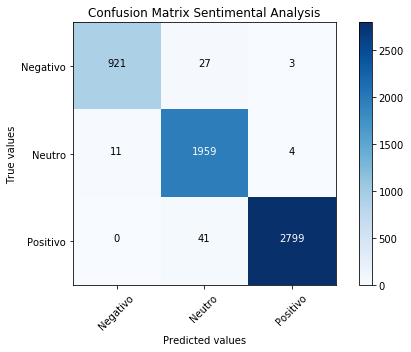

In [144]:
yp = model.predict(X)
cm = confusion_matrix(dcl[y_nm], yp)
np.set_printoptions(precision=2)
plt.figure(figsize=(7,5))
plot_confusion_matrix(cm, classes)

In [146]:
print (classification_report(dcl[y_nm],yp,classes))

              precision    recall  f1-score   support

    Positivo       1.00      0.99      0.99      2840
    Negativo       0.99      0.97      0.98       951
      Neutro       0.97      0.99      0.98      1974

    accuracy                           0.99      5765
   macro avg       0.98      0.98      0.98      5765
weighted avg       0.99      0.99      0.99      5765



In [130]:
tweets = ['Apos a ida do homem a lua, a ciencia evoluiu a passos largos','O Bozo feliz']
features_vec = vec.transform(tweets)
features_ch2_vec = ch2.transform(features_vec)
yp = model.predict(features_ch2_vec)
yp

array(['Positivo', 'Neutro'], dtype=object)

In [151]:
tweets = ['Apos a ida do homem a lua, a ciencia evoluiu a passos largos politica','A mulher gritou',
'o Garoto ficou cansado esse ano']
      
features_vec = vec.transform(tweets)
features_ch2_vec = ch2.transform(features_vec)
yp = model_win.predict(features_ch2_vec)
yp

for t, c in zip (tweets,model.predict(features_ch2_vec)):
    # t representa o tweet e c a classificação de cada tweet.
    print (t +", "+ c)

Apos a ida do homem a lua, a ciencia evoluiu a passos largos politica, Positivo
A mulher gritou, Neutro
o Garoto ficou cansado esse ano, Neutro
